Start with something simple, 1D, and only slightly nongaussian.

In [58]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [59]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

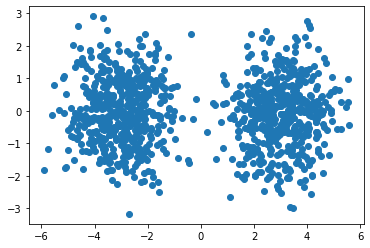

In [60]:
# Sample from the initial distribution
X1 = np.random.normal(-3, 1, 500) 
X2 = np.random.normal(3, 1, 500)  
Y  = np.random.normal(0,1,1000)

X = np.concatenate([X1 ,X2])

plt.scatter(X,Y)


The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [162]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10,10]) # not sure what hidden units are 

# Define the target distribution
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
data = np.stack([X, Y], axis=-1)

batch_size = 25
model.fit(x=data,
          y=np.zeros((1000, 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=10,
          steps_per_epoch=20,  # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)


Epoch 1/10
20/20 [==============================] - 0s 967us/step - loss: 7.2036
Epoch 2/10
20/20 [==============================] - 0s 852us/step - loss: 7.2273
Epoch 3/10
20/20 [==============================] - 0s 941us/step - loss: 7.0004
Epoch 4/10
20/20 [==============================] - 0s 843us/step - loss: 6.7639
Epoch 5/10
20/20 [==============================] - 0s 916us/step - loss: 6.5969
Epoch 6/10
20/20 [==============================] - 0s 923us/step - loss: 6.6004
Epoch 7/10
20/20 [==============================] - 0s 904us/step - loss: 6.3743
Epoch 8/10
20/20 [==============================] - 0s 884us/step - loss: 6.3300
Epoch 9/10
20/20 [==============================] - 0s 890us/step - loss: 6.2826
Epoch 10/10
20/20 [==============================] - 0s 944us/step - loss: 5.9861


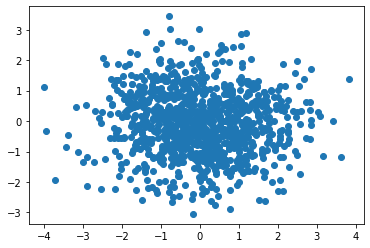

In [163]:
# Use the fitted distribution.
s=1000
samples = distribution.sample(s)
#distribution.log_prob(np.ones((3, 2), dtype=np.float32))
#print(samples)

x,y=[],[]

for i in range(0,s):
    x.append(float(samples[i][0]))
    y.append(float(samples[i][1]))

plt.scatter(x,y)

Looks pretty Gausian! Lets analyze the model a bit. I would like to plot the loss for each epoch and sample from the distribution after each epoch to get a sense of how the model flows.

[]